In [1]:
import sys, os

from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from hyppo.tools import power

In [2]:
sys.path.append(os.path.realpath('..'))
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)

POWER_REPS = 5

SIMULATIONS = {
#     "linear": ("Linear", 1000),
#     "exponential": ("Exponential", 1000),
#     "cubic": ("Cubic", 1000),
#     "joint_normal": ("Joint Normal", 10),
#     "step": ("Step", 20),
#     "quadratic": ("Quadratic", 20),
#     "w_shaped": ("W-Shaped", 20),
#     "spiral": ("Spiral", 20),
#     "uncorrelated_bernoulli": ("Bernoulli", 100),
    "logarithmic": ("Logarithmic", 100),
#     "fourth_root": ("Fourth Root", 20),
#     "sin_four_pi": ("Sine 4\u03C0", 10),
#     "sin_sixteen_pi": ("Sine 16\u03C0", 10),
#     "square": ("Square", 40),
#     "two_parabolas": ("Two Parabolas", 20),
#     "circle": ("Circle", 20),
#     "ellipse": ("Ellipse", 20),
#     "diamond": ("Diamond", 40),
#     "multiplicative_noise": ("Multiplicative", 10),
    "multimodal_independence": ("Independence", 100)
}
TESTS = [
    ["MaxMargin", "Dcorr"],
#     "KMERF",
#     "MGC",
#     "Dcorr",
#     "Hsic",
#     "HHG",
#     "CCA",
#     "RV",
]

In [3]:
def find_dim_range(dim):
    lim = 10 if dim < 20 else 20
    dim_range = list(range(int(dim/lim), dim+1, int(dim/lim)))
    if int(dim/lim) != 1:
        dim_range.insert(0, 1)
    return dim_range

In [4]:
def estimate_power(sim, test):
    dim_range = find_dim_range(SIMULATIONS[sim][1])
    est_power = np.array(
        [
            np.mean(
                [
                    power(test, sim_type="indep", sim=sim, n=100, p=i, noise=False, auto=True)
                    for _ in range(POWER_REPS)
                ]
            )
            for i in dim_range
        ]
    )
    test = test[0] if type(test) is list else test
    np.savetxt(
        "../max_margin/vs_dimension/{}_{}.csv".format(sim, test),
        est_power,
        delimiter=",",
    )

    return est_power

In [5]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim, test) for sim in SIMULATIONS.keys() for test in TESTS]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 2649.9min
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 2649.9min remaining:    0.0s


KeyboardInterrupt: 

In [ ]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25, 20))
    plt.suptitle(
        "Multivariate Independence Testing (Increasing Dimension)",
        y=0.93,
        va="baseline",
    )

    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5 * i + j
            if count in [9, 18, 19]:
                continue
            sim = list(SIMULATIONS.keys())[count]

            for test in TESTS:
                title, dim = SIMULATIONS[sim]
                dim_range = find_dim_range(dim)
                test = test[0] if type(test) is list else test
                power = np.genfromtxt(
                    "../max_margin/vs_dimension/{}_{}.csv".format(sim, test),
                    delimiter=",",
                )
                
                kwargs = {
                    "label": test,
                    "lw": 2,
                }
                if test in ["MaxMargin"]:
                    kwargs["color"] = "#e41a1c"
                    kwargs["lw"] = 4

                col.plot(dim_range, power, **kwargs)
                col.set_xticks([dim_range[0], dim_range[-1]])
                col.set_ylim(-0.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([0, 1])
                col.set_title(title)

    fig.text(0.5, 0.07, "Dimension", ha="center")
    fig.text(
        0.07,
        0.5,
        "Absolute Power",
        va="center",
        rotation="vertical",
    )
    leg = plt.legend(
        bbox_to_anchor=(0.5, 0.07),
        bbox_transform=plt.gcf().transFigure,
        ncol=len(TESTS),
        loc="upper center",
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=0.50)
    plt.savefig(
        "../max_margin/figs/indep_power_dimension.pdf", transparent=True, bbox_inches="tight"
    )

No handles with labels found to put in legend.


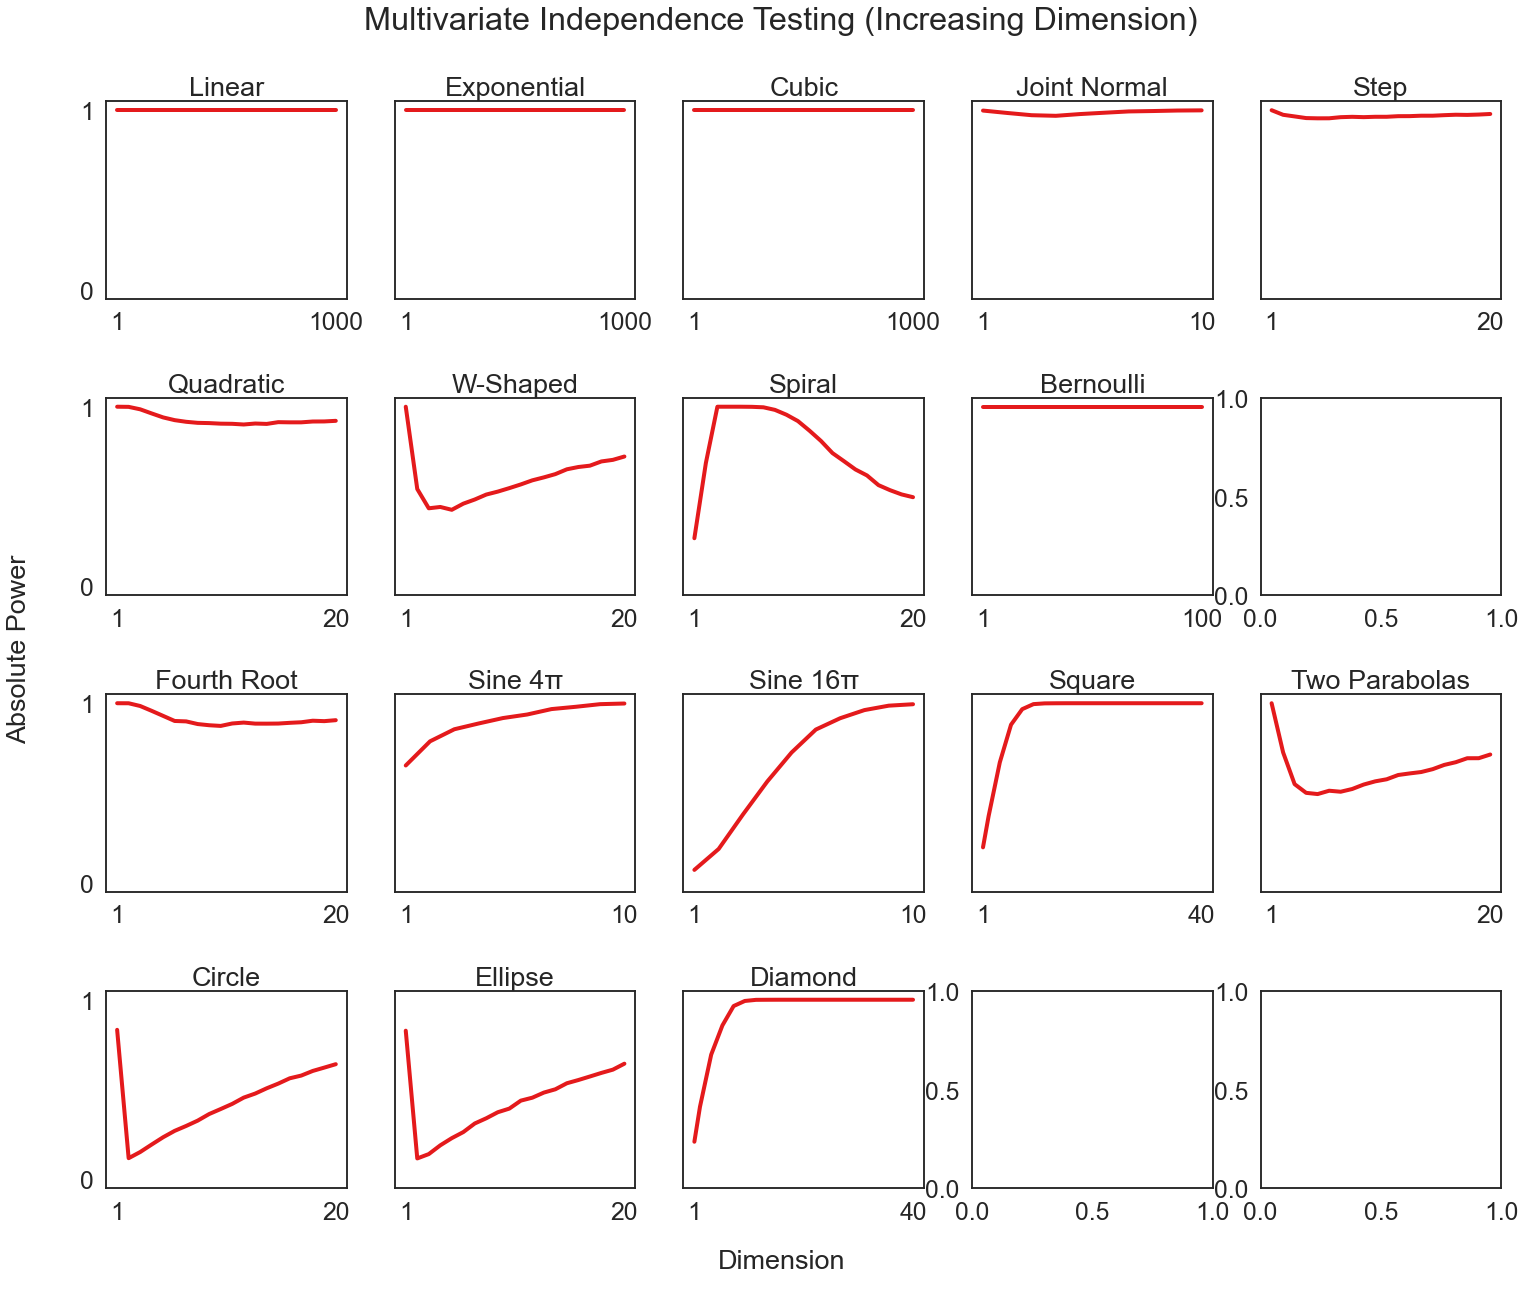

In [8]:
plot_power()